# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [53]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

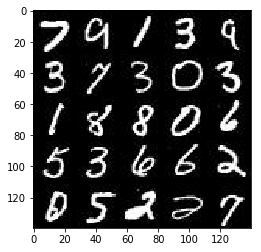

In [54]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

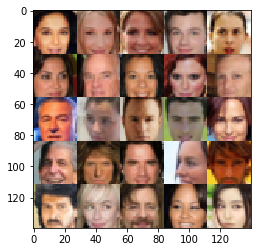

In [55]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [57]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels))
    z_input = tf.placeholder(tf.float32,(None,z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [65]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,128,3,strides=2,padding="same")
        l_relu1 = tf.maximum(alpha*x1,x1)
        #The shape of relu1 should be 14*14*128
        
        x2 = tf.layers.conv2d(l_relu1,256,3,strides=2,padding="same")
        bn2 = tf.layers.batch_normalization(x2,training=True)
        l_relu2 = tf.maximum(alpha*bn2,bn2)
        #The shape of relu2 should be 7*7*256

        #Get a flatten layer here and output to logit
        flat = tf.reshape(l_relu2,(-1,7*7*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [66]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator",reuse= not is_train):
        #Fully Connected Layer Reshape to 7*7*256
        x1 = tf.layers.dense(z,7*7*256)
        #Reshape it to rank 4 tensor
        x1 = tf.reshape(x1,(-1,7,7,256))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        relu_x1 = tf.maximum(alpha*x1,x1)
        
        #transform conv to 14*14*128
        x2 = tf.layers.conv2d_transpose(relu_x1,128,3,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        relu_x2 = tf.maximum(alpha*x2,x2)
        
        #transform back to a full image
        logits = tf.layers.conv2d_transpose(relu_x2,out_channel_dim,3,strides=2,padding='same')
        #the shape of logits is 28*28*3
        
        #apply a tanh activation function to it
        out = tf.tanh(logits) 
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [67]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #Define determinator loss for real images
    #Get the corresponding output from the generator and discriminator 
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    #Compute the loss from the output
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real+d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [68]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    #The contro_dependencies block wrap the trianing operation to allow batch_normalization layer to update hte population statistics
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [69]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [77]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    channel_size = data_shape[3]
    #get input and output
    input_real,input_z,lr = model_inputs(data_shape[1],data_shape[2],channel_size,z_dim)
    #get discriminator and generator loss
    d_loss,g_loss = model_loss(input_real,input_z,channel_size)
    #get discriminator and generator optimizer
    d_opt,g_opt = model_opt(d_loss,g_loss,lr,beta1)
    
    #initialize iterations
    ii = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #generate noise
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                #optimize discriminator
                _ = sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})
                _ = sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})
                
                #print loss info every 10 iterations
                if ii%10 == 0:
                    d_train_loss = sess.run(d_loss,feed_dict={input_real:batch_images,input_z:batch_z})
                    g_train_loss = sess.run(g_loss,feed_dict={input_real:batch_images,input_z:batch_z})
                    
                    print("Epoch:{}/{}".format(epoch_i+1,epoch_count),
                         "iteration:{}".format(ii),
                         "discriminator_loss:{:.4}".format(d_train_loss),
                         "generator_loss:{:.4}".format(g_train_loss))
                #show result every 100 iterations
                if ii%100 == 0:
                    show_generator_output(sess,25,input_z,channel_size,data_image_mode)
                
                #update iterations
                ii += 1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch:1/2 iteration:0 discriminator_loss:1.665 generator_loss:0.3515


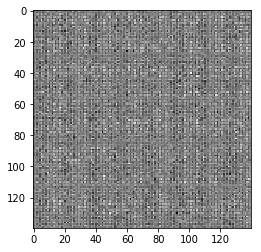

Epoch:1/2 iteration:10 discriminator_loss:0.5028 generator_loss:1.326
Epoch:1/2 iteration:20 discriminator_loss:0.3785 generator_loss:1.568
Epoch:1/2 iteration:30 discriminator_loss:0.563 generator_loss:1.258
Epoch:1/2 iteration:40 discriminator_loss:0.6278 generator_loss:1.355
Epoch:1/2 iteration:50 discriminator_loss:0.5208 generator_loss:1.649
Epoch:1/2 iteration:60 discriminator_loss:0.6494 generator_loss:0.9375
Epoch:1/2 iteration:70 discriminator_loss:0.8749 generator_loss:0.761
Epoch:1/2 iteration:80 discriminator_loss:0.6096 generator_loss:1.42
Epoch:1/2 iteration:90 discriminator_loss:0.5844 generator_loss:1.642
Epoch:1/2 iteration:100 discriminator_loss:0.6593 generator_loss:0.9749


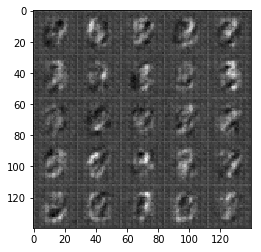

Epoch:1/2 iteration:110 discriminator_loss:0.4787 generator_loss:1.457
Epoch:1/2 iteration:120 discriminator_loss:0.5163 generator_loss:1.195
Epoch:1/2 iteration:130 discriminator_loss:0.4468 generator_loss:1.355
Epoch:1/2 iteration:140 discriminator_loss:0.3977 generator_loss:1.665
Epoch:1/2 iteration:150 discriminator_loss:0.3678 generator_loss:1.945
Epoch:1/2 iteration:160 discriminator_loss:0.3341 generator_loss:2.079
Epoch:1/2 iteration:170 discriminator_loss:0.3666 generator_loss:1.821
Epoch:1/2 iteration:180 discriminator_loss:0.4395 generator_loss:1.334
Epoch:1/2 iteration:190 discriminator_loss:0.3456 generator_loss:1.728
Epoch:1/2 iteration:200 discriminator_loss:0.2665 generator_loss:2.038


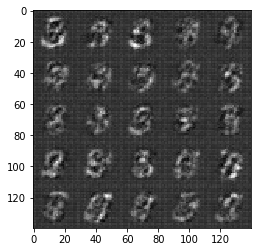

Epoch:1/2 iteration:210 discriminator_loss:0.2752 generator_loss:2.158
Epoch:1/2 iteration:220 discriminator_loss:0.2698 generator_loss:1.918
Epoch:1/2 iteration:230 discriminator_loss:0.2522 generator_loss:2.384
Epoch:1/2 iteration:240 discriminator_loss:0.2456 generator_loss:1.965
Epoch:1/2 iteration:250 discriminator_loss:0.2527 generator_loss:1.919
Epoch:1/2 iteration:260 discriminator_loss:0.4872 generator_loss:1.098
Epoch:1/2 iteration:270 discriminator_loss:0.3013 generator_loss:1.828
Epoch:1/2 iteration:280 discriminator_loss:0.2446 generator_loss:2.133
Epoch:1/2 iteration:290 discriminator_loss:0.2718 generator_loss:1.885
Epoch:1/2 iteration:300 discriminator_loss:0.2569 generator_loss:1.965


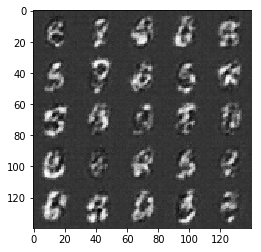

Epoch:1/2 iteration:310 discriminator_loss:0.2445 generator_loss:2.239
Epoch:1/2 iteration:320 discriminator_loss:0.2252 generator_loss:2.234
Epoch:1/2 iteration:330 discriminator_loss:0.1837 generator_loss:2.755
Epoch:1/2 iteration:340 discriminator_loss:0.2046 generator_loss:2.541
Epoch:1/2 iteration:350 discriminator_loss:0.1959 generator_loss:2.542
Epoch:1/2 iteration:360 discriminator_loss:0.2349 generator_loss:2.099
Epoch:1/2 iteration:370 discriminator_loss:0.1952 generator_loss:2.666
Epoch:1/2 iteration:380 discriminator_loss:0.1805 generator_loss:3.377
Epoch:1/2 iteration:390 discriminator_loss:0.177 generator_loss:2.496
Epoch:1/2 iteration:400 discriminator_loss:0.1509 generator_loss:3.077


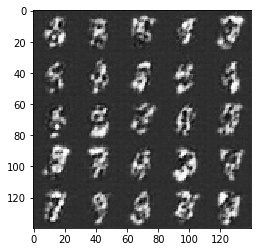

Epoch:1/2 iteration:410 discriminator_loss:0.1637 generator_loss:2.646
Epoch:1/2 iteration:420 discriminator_loss:0.139 generator_loss:2.786
Epoch:1/2 iteration:430 discriminator_loss:0.1831 generator_loss:2.45
Epoch:1/2 iteration:440 discriminator_loss:0.1388 generator_loss:3.049
Epoch:1/2 iteration:450 discriminator_loss:0.1249 generator_loss:3.19
Epoch:1/2 iteration:460 discriminator_loss:0.1278 generator_loss:2.997
Epoch:2/2 iteration:470 discriminator_loss:0.1328 generator_loss:2.949
Epoch:2/2 iteration:480 discriminator_loss:0.1096 generator_loss:3.45
Epoch:2/2 iteration:490 discriminator_loss:0.1082 generator_loss:3.07
Epoch:2/2 iteration:500 discriminator_loss:0.1105 generator_loss:3.302


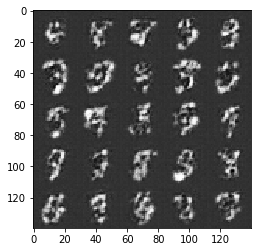

Epoch:2/2 iteration:510 discriminator_loss:0.1292 generator_loss:3.08
Epoch:2/2 iteration:520 discriminator_loss:0.1259 generator_loss:3.441
Epoch:2/2 iteration:530 discriminator_loss:0.1022 generator_loss:3.33
Epoch:2/2 iteration:540 discriminator_loss:0.1497 generator_loss:2.586
Epoch:2/2 iteration:550 discriminator_loss:0.1309 generator_loss:3.039
Epoch:2/2 iteration:560 discriminator_loss:0.1444 generator_loss:2.72
Epoch:2/2 iteration:570 discriminator_loss:0.09047 generator_loss:3.378
Epoch:2/2 iteration:580 discriminator_loss:0.123 generator_loss:2.998
Epoch:2/2 iteration:590 discriminator_loss:0.1142 generator_loss:3.194
Epoch:2/2 iteration:600 discriminator_loss:0.115 generator_loss:3.335


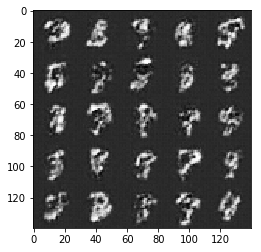

Epoch:2/2 iteration:610 discriminator_loss:0.08876 generator_loss:3.267
Epoch:2/2 iteration:620 discriminator_loss:0.1035 generator_loss:3.244
Epoch:2/2 iteration:630 discriminator_loss:0.6425 generator_loss:1.503
Epoch:2/2 iteration:640 discriminator_loss:0.4685 generator_loss:1.904
Epoch:2/2 iteration:650 discriminator_loss:0.1669 generator_loss:2.723
Epoch:2/2 iteration:660 discriminator_loss:0.1409 generator_loss:3.505
Epoch:2/2 iteration:670 discriminator_loss:0.1195 generator_loss:3.261
Epoch:2/2 iteration:680 discriminator_loss:0.1139 generator_loss:3.303
Epoch:2/2 iteration:690 discriminator_loss:0.1381 generator_loss:3.181
Epoch:2/2 iteration:700 discriminator_loss:0.1622 generator_loss:3.004


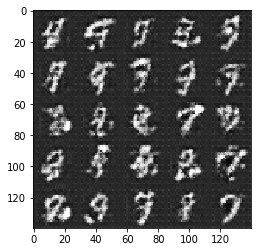

Epoch:2/2 iteration:710 discriminator_loss:0.1323 generator_loss:3.087
Epoch:2/2 iteration:720 discriminator_loss:0.1064 generator_loss:3.476
Epoch:2/2 iteration:730 discriminator_loss:0.1333 generator_loss:3.127
Epoch:2/2 iteration:740 discriminator_loss:0.152 generator_loss:2.89
Epoch:2/2 iteration:750 discriminator_loss:0.1505 generator_loss:2.988
Epoch:2/2 iteration:760 discriminator_loss:0.1487 generator_loss:2.896
Epoch:2/2 iteration:770 discriminator_loss:0.1474 generator_loss:2.894
Epoch:2/2 iteration:780 discriminator_loss:0.1641 generator_loss:2.735
Epoch:2/2 iteration:790 discriminator_loss:0.1575 generator_loss:2.876
Epoch:2/2 iteration:800 discriminator_loss:0.1968 generator_loss:2.429


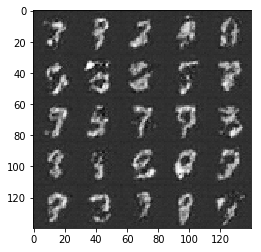

Epoch:2/2 iteration:810 discriminator_loss:0.1796 generator_loss:2.785
Epoch:2/2 iteration:820 discriminator_loss:0.1325 generator_loss:2.972
Epoch:2/2 iteration:830 discriminator_loss:0.1384 generator_loss:2.914
Epoch:2/2 iteration:840 discriminator_loss:0.1626 generator_loss:3.013
Epoch:2/2 iteration:850 discriminator_loss:0.1515 generator_loss:2.803
Epoch:2/2 iteration:860 discriminator_loss:0.1438 generator_loss:3.047
Epoch:2/2 iteration:870 discriminator_loss:0.1557 generator_loss:2.728
Epoch:2/2 iteration:880 discriminator_loss:0.1644 generator_loss:2.988
Epoch:2/2 iteration:890 discriminator_loss:0.1324 generator_loss:2.899
Epoch:2/2 iteration:900 discriminator_loss:0.1303 generator_loss:2.889


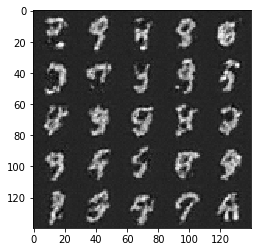

Epoch:2/2 iteration:910 discriminator_loss:0.2036 generator_loss:2.669
Epoch:2/2 iteration:920 discriminator_loss:0.1643 generator_loss:2.621
Epoch:2/2 iteration:930 discriminator_loss:0.09474 generator_loss:3.259


In [78]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch:1/1 iteration:0 discriminator_loss:2.109 generator_loss:0.2072


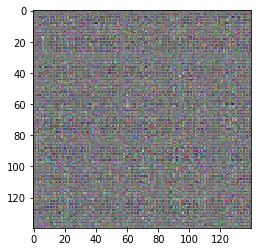

Epoch:1/1 iteration:10 discriminator_loss:0.8831 generator_loss:0.8944
Epoch:1/1 iteration:20 discriminator_loss:0.6022 generator_loss:1.338
Epoch:1/1 iteration:30 discriminator_loss:0.5106 generator_loss:1.569
Epoch:1/1 iteration:40 discriminator_loss:0.458 generator_loss:1.745
Epoch:1/1 iteration:50 discriminator_loss:0.4075 generator_loss:1.83
Epoch:1/1 iteration:60 discriminator_loss:0.3622 generator_loss:1.841
Epoch:1/1 iteration:70 discriminator_loss:0.322 generator_loss:2.008
Epoch:1/1 iteration:80 discriminator_loss:0.5051 generator_loss:1.239
Epoch:1/1 iteration:90 discriminator_loss:0.3665 generator_loss:2.551
Epoch:1/1 iteration:100 discriminator_loss:0.5846 generator_loss:1.335


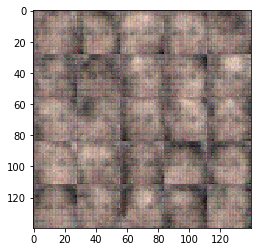

Epoch:1/1 iteration:110 discriminator_loss:0.5799 generator_loss:1.551
Epoch:1/1 iteration:120 discriminator_loss:0.6797 generator_loss:1.213
Epoch:1/1 iteration:130 discriminator_loss:0.5961 generator_loss:1.38
Epoch:1/1 iteration:140 discriminator_loss:0.7221 generator_loss:1.171
Epoch:1/1 iteration:150 discriminator_loss:0.7035 generator_loss:1.315
Epoch:1/1 iteration:160 discriminator_loss:0.7718 generator_loss:2.097
Epoch:1/1 iteration:170 discriminator_loss:0.6441 generator_loss:1.77
Epoch:1/1 iteration:180 discriminator_loss:0.5271 generator_loss:1.884
Epoch:1/1 iteration:190 discriminator_loss:0.556 generator_loss:1.304
Epoch:1/1 iteration:200 discriminator_loss:0.6459 generator_loss:1.536


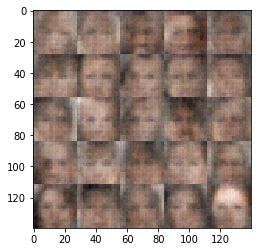

Epoch:1/1 iteration:210 discriminator_loss:1.058 generator_loss:1.746
Epoch:1/1 iteration:220 discriminator_loss:0.7035 generator_loss:1.982
Epoch:1/1 iteration:230 discriminator_loss:0.7053 generator_loss:1.141
Epoch:1/1 iteration:240 discriminator_loss:0.8765 generator_loss:0.9289
Epoch:1/1 iteration:250 discriminator_loss:0.755 generator_loss:3.015
Epoch:1/1 iteration:260 discriminator_loss:0.7554 generator_loss:1.236
Epoch:1/1 iteration:270 discriminator_loss:0.5773 generator_loss:1.714
Epoch:1/1 iteration:280 discriminator_loss:0.5708 generator_loss:2.605
Epoch:1/1 iteration:290 discriminator_loss:0.3619 generator_loss:2.118
Epoch:1/1 iteration:300 discriminator_loss:0.6385 generator_loss:1.357


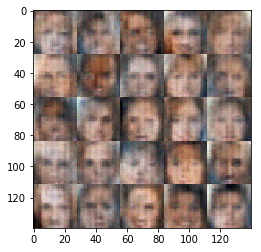

Epoch:1/1 iteration:310 discriminator_loss:0.5158 generator_loss:2.49
Epoch:1/1 iteration:320 discriminator_loss:0.4314 generator_loss:3.707
Epoch:1/1 iteration:330 discriminator_loss:0.5201 generator_loss:1.433
Epoch:1/1 iteration:340 discriminator_loss:0.6385 generator_loss:1.579
Epoch:1/1 iteration:350 discriminator_loss:0.426 generator_loss:1.485
Epoch:1/1 iteration:360 discriminator_loss:0.5444 generator_loss:1.613
Epoch:1/1 iteration:370 discriminator_loss:0.3921 generator_loss:3.906
Epoch:1/1 iteration:380 discriminator_loss:0.2211 generator_loss:2.474
Epoch:1/1 iteration:390 discriminator_loss:0.7741 generator_loss:1.347
Epoch:1/1 iteration:400 discriminator_loss:0.3009 generator_loss:3.174


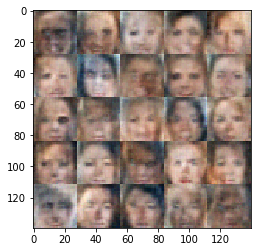

Epoch:1/1 iteration:410 discriminator_loss:0.4507 generator_loss:2.111
Epoch:1/1 iteration:510 discriminator_loss:0.3532 generator_loss:2.731
Epoch:1/1 iteration:520 discriminator_loss:0.5433 generator_loss:4.567
Epoch:1/1 iteration:530 discriminator_loss:1.21 generator_loss:0.4754
Epoch:1/1 iteration:540 discriminator_loss:0.4267 generator_loss:2.302
Epoch:1/1 iteration:550 discriminator_loss:0.1758 generator_loss:4.744
Epoch:1/1 iteration:560 discriminator_loss:0.5028 generator_loss:1.556
Epoch:1/1 iteration:570 discriminator_loss:0.6521 generator_loss:3.525
Epoch:1/1 iteration:580 discriminator_loss:0.2731 generator_loss:5.257
Epoch:1/1 iteration:590 discriminator_loss:0.6813 generator_loss:1.572
Epoch:1/1 iteration:600 discriminator_loss:0.6793 generator_loss:1.036


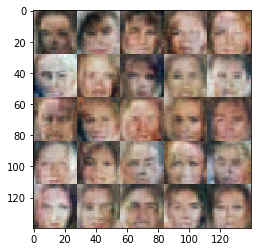

Epoch:1/1 iteration:610 discriminator_loss:0.2437 generator_loss:3.644
Epoch:1/1 iteration:620 discriminator_loss:0.2828 generator_loss:4.339
Epoch:1/1 iteration:630 discriminator_loss:0.1875 generator_loss:6.383
Epoch:1/1 iteration:640 discriminator_loss:0.2913 generator_loss:4.469
Epoch:1/1 iteration:650 discriminator_loss:0.9489 generator_loss:0.6346
Epoch:1/1 iteration:660 discriminator_loss:0.3985 generator_loss:6.186
Epoch:1/1 iteration:670 discriminator_loss:1.028 generator_loss:0.5697
Epoch:1/1 iteration:680 discriminator_loss:0.3839 generator_loss:1.634
Epoch:1/1 iteration:690 discriminator_loss:0.2021 generator_loss:4.256
Epoch:1/1 iteration:700 discriminator_loss:1.248 generator_loss:0.3951


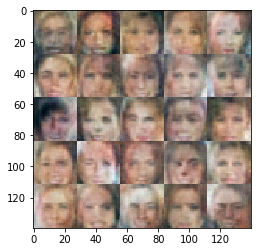

Epoch:1/1 iteration:710 discriminator_loss:0.4304 generator_loss:8.359
Epoch:1/1 iteration:720 discriminator_loss:1.488 generator_loss:0.3306
Epoch:1/1 iteration:730 discriminator_loss:0.3512 generator_loss:2.24
Epoch:1/1 iteration:740 discriminator_loss:1.088 generator_loss:0.5366
Epoch:1/1 iteration:750 discriminator_loss:0.3781 generator_loss:1.582
Epoch:1/1 iteration:760 discriminator_loss:0.7984 generator_loss:7.965
Epoch:1/1 iteration:770 discriminator_loss:0.7666 generator_loss:0.8011
Epoch:1/1 iteration:780 discriminator_loss:0.2018 generator_loss:4.338
Epoch:1/1 iteration:790 discriminator_loss:0.6104 generator_loss:1.479
Epoch:1/1 iteration:800 discriminator_loss:0.2213 generator_loss:4.495


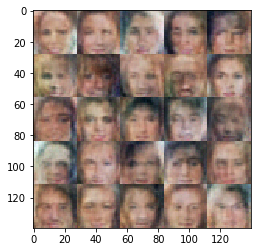

Epoch:1/1 iteration:810 discriminator_loss:0.08239 generator_loss:8.965
Epoch:1/1 iteration:820 discriminator_loss:0.5158 generator_loss:1.141
Epoch:1/1 iteration:830 discriminator_loss:0.4447 generator_loss:4.2
Epoch:1/1 iteration:840 discriminator_loss:0.3598 generator_loss:3.499
Epoch:1/1 iteration:850 discriminator_loss:0.1266 generator_loss:10.28
Epoch:1/1 iteration:860 discriminator_loss:0.4099 generator_loss:9.662
Epoch:1/1 iteration:870 discriminator_loss:0.6636 generator_loss:2.463
Epoch:1/1 iteration:880 discriminator_loss:0.1615 generator_loss:3.682
Epoch:1/1 iteration:890 discriminator_loss:0.2359 generator_loss:4.628
Epoch:1/1 iteration:900 discriminator_loss:0.8727 generator_loss:0.7796


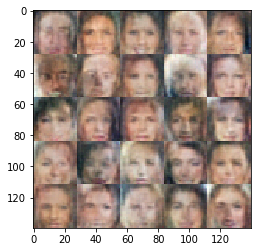

Epoch:1/1 iteration:910 discriminator_loss:0.9355 generator_loss:3.93
Epoch:1/1 iteration:920 discriminator_loss:1.019 generator_loss:0.7346
Epoch:1/1 iteration:930 discriminator_loss:0.2242 generator_loss:11.17
Epoch:1/1 iteration:940 discriminator_loss:0.2818 generator_loss:2.564
Epoch:1/1 iteration:950 discriminator_loss:0.136 generator_loss:4.612
Epoch:1/1 iteration:960 discriminator_loss:1.407 generator_loss:0.3357
Epoch:1/1 iteration:970 discriminator_loss:0.2316 generator_loss:2.534
Epoch:1/1 iteration:980 discriminator_loss:0.3005 generator_loss:2.037
Epoch:1/1 iteration:990 discriminator_loss:0.1758 generator_loss:3.266
Epoch:1/1 iteration:1000 discriminator_loss:1.23 generator_loss:0.6906


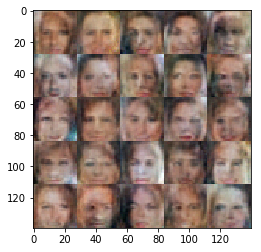

Epoch:1/1 iteration:1010 discriminator_loss:0.2965 generator_loss:4.205
Epoch:1/1 iteration:1020 discriminator_loss:0.06452 generator_loss:8.967
Epoch:1/1 iteration:1030 discriminator_loss:0.2887 generator_loss:4.995
Epoch:1/1 iteration:1040 discriminator_loss:1.398 generator_loss:0.3451
Epoch:1/1 iteration:1050 discriminator_loss:0.5255 generator_loss:7.92
Epoch:1/1 iteration:1060 discriminator_loss:0.2612 generator_loss:1.986
Epoch:1/1 iteration:1070 discriminator_loss:0.1616 generator_loss:10.49
Epoch:1/1 iteration:1080 discriminator_loss:0.8901 generator_loss:0.6899
Epoch:1/1 iteration:1090 discriminator_loss:0.2085 generator_loss:4.688
Epoch:1/1 iteration:1100 discriminator_loss:1.462 generator_loss:0.3325


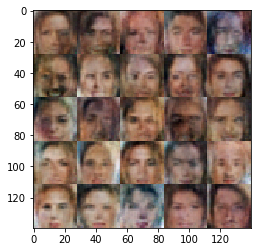

Epoch:1/1 iteration:1110 discriminator_loss:0.1062 generator_loss:5.626
Epoch:1/1 iteration:1120 discriminator_loss:0.1314 generator_loss:5.717
Epoch:1/1 iteration:1130 discriminator_loss:0.1123 generator_loss:5.524
Epoch:1/1 iteration:1140 discriminator_loss:0.1657 generator_loss:3.886
Epoch:1/1 iteration:1150 discriminator_loss:0.2875 generator_loss:9.719
Epoch:1/1 iteration:1160 discriminator_loss:0.6106 generator_loss:1.811
Epoch:1/1 iteration:1170 discriminator_loss:0.9032 generator_loss:0.7356
Epoch:1/1 iteration:1180 discriminator_loss:0.1337 generator_loss:5.374
Epoch:1/1 iteration:1190 discriminator_loss:1.069 generator_loss:0.7608
Epoch:1/1 iteration:1200 discriminator_loss:0.1044 generator_loss:4.56


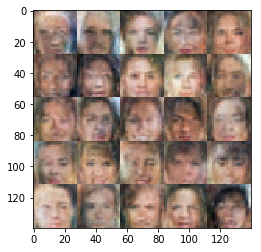

Epoch:1/1 iteration:1210 discriminator_loss:0.2596 generator_loss:7.507
Epoch:1/1 iteration:1220 discriminator_loss:0.2033 generator_loss:8.499
Epoch:1/1 iteration:1230 discriminator_loss:0.1692 generator_loss:4.984
Epoch:1/1 iteration:1240 discriminator_loss:0.1613 generator_loss:10.54
Epoch:1/1 iteration:1250 discriminator_loss:0.2805 generator_loss:1.957
Epoch:1/1 iteration:1260 discriminator_loss:0.1553 generator_loss:4.288
Epoch:1/1 iteration:1270 discriminator_loss:0.2792 generator_loss:2.392
Epoch:1/1 iteration:1280 discriminator_loss:1.949 generator_loss:0.1802
Epoch:1/1 iteration:1290 discriminator_loss:0.1439 generator_loss:3.273
Epoch:1/1 iteration:1300 discriminator_loss:0.1317 generator_loss:10.93


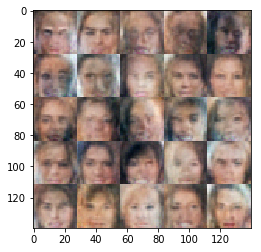

Epoch:1/1 iteration:1310 discriminator_loss:0.648 generator_loss:1.01
Epoch:1/1 iteration:1320 discriminator_loss:0.3084 generator_loss:8.714
Epoch:1/1 iteration:1330 discriminator_loss:0.8892 generator_loss:1.047
Epoch:1/1 iteration:1340 discriminator_loss:0.3861 generator_loss:1.663
Epoch:1/1 iteration:1350 discriminator_loss:0.3521 generator_loss:9.189
Epoch:1/1 iteration:1360 discriminator_loss:0.4471 generator_loss:1.449
Epoch:1/1 iteration:1370 discriminator_loss:0.1344 generator_loss:8.84
Epoch:1/1 iteration:1380 discriminator_loss:0.3845 generator_loss:1.79
Epoch:1/1 iteration:1390 discriminator_loss:0.3014 generator_loss:3.789
Epoch:1/1 iteration:1400 discriminator_loss:0.2294 generator_loss:4.536


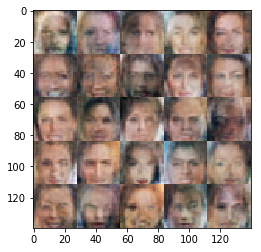

Epoch:1/1 iteration:1410 discriminator_loss:0.5877 generator_loss:1.192
Epoch:1/1 iteration:1420 discriminator_loss:0.1477 generator_loss:7.181
Epoch:1/1 iteration:1430 discriminator_loss:0.4562 generator_loss:1.485
Epoch:1/1 iteration:1440 discriminator_loss:0.239 generator_loss:3.016
Epoch:1/1 iteration:1450 discriminator_loss:0.5748 generator_loss:1.108
Epoch:1/1 iteration:1460 discriminator_loss:0.1644 generator_loss:4.902
Epoch:1/1 iteration:1470 discriminator_loss:1.179 generator_loss:0.4629
Epoch:1/1 iteration:1480 discriminator_loss:0.08801 generator_loss:5.488
Epoch:1/1 iteration:1490 discriminator_loss:0.2487 generator_loss:2.621
Epoch:1/1 iteration:1500 discriminator_loss:0.8156 generator_loss:1.456


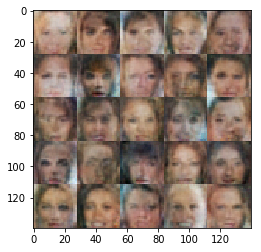

Epoch:1/1 iteration:1510 discriminator_loss:0.3248 generator_loss:1.965
Epoch:1/1 iteration:1520 discriminator_loss:0.08963 generator_loss:10.48
Epoch:1/1 iteration:1530 discriminator_loss:0.6134 generator_loss:1.084
Epoch:1/1 iteration:1540 discriminator_loss:1.148 generator_loss:0.5225
Epoch:1/1 iteration:1550 discriminator_loss:0.193 generator_loss:7.941
Epoch:1/1 iteration:1560 discriminator_loss:0.1904 generator_loss:4.644
Epoch:1/1 iteration:1570 discriminator_loss:0.04604 generator_loss:6.868
Epoch:1/1 iteration:1580 discriminator_loss:0.5328 generator_loss:9.444


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.